# Tutorial demonstrating verification of v1 SOI index against jra55

#### Import pyLatte package

In [1]:
from pylatte import utils
from pylatte import skill
from pylatte import indices

#### Currently, the following packages are required to load the data - this process will be replaced by the CAFE cookbook

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import glob

#### Import some plotting packages and widgets

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings    
warnings.filterwarnings("ignore")

# Jupyter specific -----
from ipywidgets import FloatProgress
%matplotlib inline

# A note about the methodology of pyLatte
The pyLatte package is constructed around the xarray Python package. This is particularly useful for verification computations which require large numbers of samples (different model runs) to converge. 

The approach here is to generate very large xarray objects that reference all data required for the verification, but do not store the data in memory. Operations are performed on these xarray objects out-of-memory. When it is necessary to perform a compute (e.g. to produce a plot), this is distributed over multiple processors using the dask Python package.

# Initialise dask (currently not working on vm31)

In [4]:
# import dask
# import distributed
# client = distributed.Client(local_dir='/tmp/squ027-dask-worker-space', n_workers=4, ip='*')
# client

# Construct xarray objects for forecasts and observations
(The CAFE cookbook will replace these code blocks)

In [5]:
# Location of forecast data -----
fcst_folder = '/OSM/CBR/OA_DCFP/data/model_output/CAFE/forecasts/v1/'
fcst_filename = 'atmos_daily*'
fcst_variable = 'slp'

# Location of observation data -----
obsv_folder = '/OSM/CBR/OA_DCFP/data/observations/jra55/isobaric/002_prmsl/cat/'
obsv_filename = 'jra.55.prmsl.000.1958010100_2016123118.nc'
obsv_variable = 'PRMSL_GDS0_MSL'

In [95]:
# Initial dates to include (takes approximately 1 min 30 sec per date) -----
init_dates = pd.date_range('2013-4','2016-4' , freq='1MS')

# Ensembles to include -----
ensembles = range(1,12)

# Forecast length -----
FCST_LENGTH = 2 # years

In [96]:
# Resampling details -----
resample_freq = 'MS'

### Construct forecasts xarray object
Note, dask has a known bug that manifests when trying to concatentate data containing timedelta64 arrays (see https://github.com/pydata/xarray/issues/1952 for further details). For example, try to concatenate the following two Datasets:

`In : path = '/OSM/CBR/OA_DCFP/data/model_output/CAFE/forecasts/v1/yr2002/mn7/'`

`In : ens5 = xr.open_mfdataset(path + 'OUTPUT.5/atmos_daily*.nc', autoclose=True)`

`In : ens6 = xr.open_mfdataset(path + 'OUTPUT.6/atmos_daily*.nc', autoclose=True)`

`In : xr.concat([ens5, ens6],'ensemble')`

`Out : TypeError: invalid type promotion`

The error here is actually caused by the variables `average_DT` and `time_bounds`, which are timedelta64 arrays. However, I still do not fully unstand the bug: concatenation of `ens4` and `ens5`, for example, works fine, even though `ens4` also contains the timedelta64 variables `average_DT` and `time_bounds`. Regardless, because of this bug, it is not possible currently to create an xarray Dataset object containing all model variables. Instead, only the variable of interest (i.e. `fcst_variable` and `obsv_variable`) are retained in the concatenated xarray object.

In [99]:
# Instantiate progress bar -----
f = FloatProgress(min=0, max=len(init_dates)*len(ensembles), description='Loading...') 
display(f)

# Loop over initial dates -----
fcst_list = []
for init_date in init_dates:
    year = init_date.year
    month = init_date.month
    
    # Loop over ensembles -----
    ens_list = []
    for ensemble in ensembles:
        # Signal to increment the progress bar -----
        f.value += 1 
        
        
        path = fcst_folder + '/yr' + str(year) + '/mn' + str(month) + \
               '/OUTPUT.' + str(ensemble) + '/' + fcst_filename + '.nc'
            
        # xr.open_mfdataset() is slow - manually concatenate in time -----
        files = glob.glob(path)
        datasets = []
        for file in files:
            dataset = xr.open_dataset(file, autoclose=True)[fcst_variable]
            datasets.append(dataset)
        dataset = xr.concat(datasets, dim='time', coords='all').sortby('time')
        
        # Stack ensembles into a list -----
        ens_list.append(dataset.resample(time=resample_freq) \
                               .mean(dim='time'))
        
    # Concatenate ensembles -----
    ens_object = xr.concat(ens_list, dim='ensemble')
    ens_object['ensemble'] = ensembles
    
    # Stack concatenated ensembles into a list for each initial date -----                       
    fcst_list.append(utils.datetime_to_leadtime(ens_object))

# Keep track of the lead time for each initialization -----
n_lead_time = [len(x.lead_time) for x in fcst_list]

# Concatenate initial dates -----
da_fcst = xr.concat(fcst_list, dim='init_date')

# Rechunk for chunksizes of at least 1,000,000 elements -----
da_fcst = utils.prune(da_fcst.chunk(chunks={'ensemble' : len(da_fcst.ensemble), 
                                            'lead_time' : len(da_fcst.lead_time)}).squeeze())

FloatProgress(value=0.0, description='Loading...', max=407.0)

#### Truncate the forecast lead times at 2 years
The January and July forecasts are run for 5 years rather than 2 years. The xarray concatenation above can deal with this, but fills the shorter forecasts with nans for lead times longer than 2 years. Let's get rid of some of these nans by truncating the forecasts at the lead time corresponding to the longest 2 year forecast.

In [100]:
max_increments = FCST_LENGTH * 12
n_trunc = max([i for i in n_lead_time if i <= max_increments])
da_fcst = da_fcst.isel(lead_time=range(n_trunc))

### Construct observations xarray object

In [103]:
# Instantiate progress bar -----
f = FloatProgress(min=0, max=1, description='Loading...') 
display(f)

# JRA temperature fields are only save in a time-concatenated form -----
path = obsv_folder + obsv_filename
dataset = xr.open_mfdataset(path, autoclose=True)[obsv_variable]
da_obsv = dataset.rename(fcst_variable) \
                 .rename({'initial_time0_hours' : 'time', 'g0_lon_2' : 'lon', 'g0_lat_1' : 'lat'}) \
                 .resample(time=resample_freq) \
                 .mean(dim='time')

# Stack by initial date to match forecast structure -----
# da_obsv = utils.stack_by_init_date(da_obsv,da_fcst.init_date.values,n_trunc)
f.value += 1

# Average over forecast dimension if it is exists -----
# if 'forecast_time1' in da_obsv.coords:
#     da_obsv = da_obsv.mean(dim='forecast_time1')

# Rechunk for chunksizes of at least 1,000,000 elements -----
# da_obsv = utils.prune(da_obsv.chunk(chunks={'init_date' : len(da_obsv.init_date)}).squeeze())

FloatProgress(value=0.0, description='Loading...', max=1.0)

# L'Heureux plot

In [375]:
import importlib
utils = importlib.reload(utils)

### Observations
#### Get appropriate years

In [112]:
da_obsv = da_obsv.isel(time=range(663,708))

#### Load climatology

In [271]:
da_obsv_clim = utils.load_mean_climatology('jra_1958-2016', 'slp', freq='MS')

#### Anomalize

In [272]:
da_obsv_anom = utils.anomalize(da_obsv, da_obsv_clim)

#### Compute and smooth SOI

In [328]:
soi_obsv = indices.compute_soi(da_obsv_anom, std_dim='time') \
                  .rolling(time=3, min_periods=1) \
                  .mean(dim='time') \
                  .compute()

### Forecasts
#### Load climatology

In [364]:
da_fcst_clim = utils.load_mean_climatology('cafe_fcst_v1_atmos_2003-2021', 'slp', freq='MS') * 100

#### Anomalize

In [376]:
anomalize = lambda data, clim: utils.datetime_to_leadtime(
                                   utils.anomalize(
                                       utils.leadtime_to_datetime(data),clim))

In [377]:
da_fcst_anom = (100 * da_fcst).groupby('init_date').apply(anomalize, clim=da_fcst_clim)

#### Compute and smooth SOI

In [368]:
soi_fcst = indices.compute_soi(da_fcst_anom, std_dim='lead_time') \
                  .rolling(lead_time=3, min_periods=1) \
                  .mean(dim='lead_time') \
                  .compute()

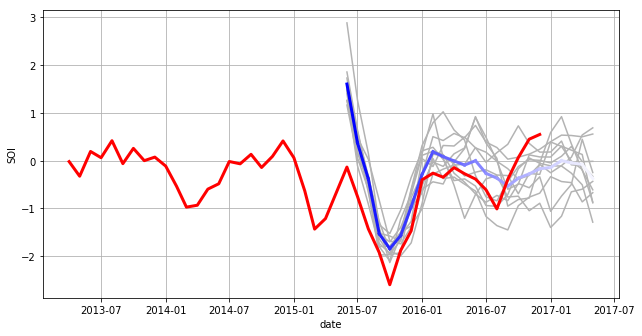

In [386]:
def plot_each(data,ax):
    # Plot ensembles
    sp = utils.leadtime_to_datetime(data)
    ax.plot(sp['time'],sp.transpose(),color=(0.7,0.7,0.7))
    
    ts = utils.leadtime_to_datetime(data).mean(dim='ensemble')
    x = ts['time'].values
    y = ts.values
    
    # Your colouring array
    T = np.linspace(0,1,np.size(x))

    # Segement plot and colour depending on T
    s = 1 # Segment length
    for i in range(0,len(x)-s,s):
        ax.plot(x[i:i+s+1], y[i:i+s+1], color=(T[i],T[i],1), linewidth=3)
    
    return ts

fig1 = plt.figure(figsize=(10,5))

ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
lines = soi_fcst.sel(init_date='2015-06').groupby('init_date').apply(plot_each,ax=ax)
ax.plot(soi_obsv['time'],soi_obsv,'r-',linewidth=3)
ax.set_xlabel('date')
ax.set_ylabel('SOI');

# Compute the SOI index

##### Extract forecast and observation
Note, we `compute()` the xarray objects here to save time later on. Once dask is working, it will probably be most sensible to leave the objects uncomputed.

In [74]:
with utils.timer():
    da_fcst = da_fcst.compute() * 100
    da_obsv = da_obsv.compute()

   Elapsed: 21.83656930923462 sec


##### Load climatology data
Various climatologies are/will be accessable using `utils.load_mean_climatology()`.

In [75]:
cafe_clim = utils.load_mean_climatology('cafe_fcst_v1_atmos_2003-2021', 'slp', freq='MS')

da_fcst_clim = cafe_clim.compute() * 100

In [76]:
jra_clim = utils.load_mean_climatology('jra_1958-2016', 'slp', freq='MS')

da_obsv_clim = jra_clim.compute()

##### Compute anomaly data
Recall that the forecast and observation data are saved as functions of lead time and initial date. The function `utils.anomalize()` computes anomalies given data and a climatology which each have a datetime dimension `time`. Thus it is necessary to first convert from the lead time/initial date format to a datetime format, then compute the anomaly, the convert back to the lead time/initial date format.  

In [77]:
anomalize = lambda data, clim: utils.datetime_to_leadtime(
                                   utils.anomalize(
                                       utils.leadtime_to_datetime(data),clim))

In [78]:
da_fcst_anom = da_fcst.groupby('init_date').apply(anomalize, clim=da_fcst_clim)

da_obsv_anom = da_obsv.groupby('init_date').apply(anomalize, clim=da_obsv_clim)

In [79]:
soi_obsv = indices.compute_soi(da_obsv_anom, std_dim='lead_time')

soi_fcst = indices.compute_soi(da_fcst_anom, std_dim='lead_time')

##### Compute persistence data
This requires repeating the data at the first lead time over all lead times. `utils.repeat_data()` allows us to do this

In [80]:
soi_pers = utils.repeat_data(soi_obsv,'lead_time')

### Plot one initialization date

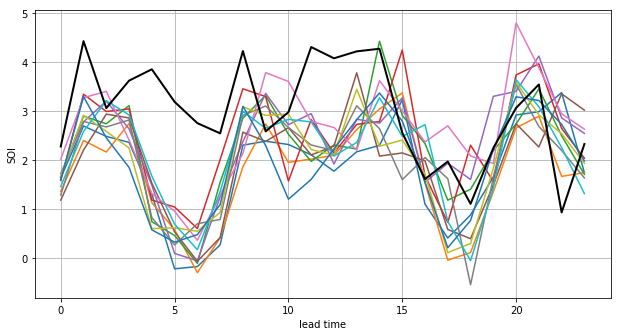

In [81]:
fig1 = plt.figure(figsize=(10,5))

ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
ax.grid()
ax.plot(soi_fcst['lead_time'],soi_fcst.isel(init_date=[2]).squeeze().transpose())
ax.plot(soi_obsv['lead_time'],soi_obsv.isel(init_date=[2]).squeeze(),'k-',linewidth=2)
ax.set_xlabel('lead time')
ax.set_ylabel('SOI');

# Compute some skill metrics

## Root mean squared error

In [82]:
with utils.timer():
    rms_error = skill.compute_rms_error(soi_fcst, soi_obsv, over_dims='ensemble') \
                     .groupby('init_date.month').mean(dim='init_date')

   Elapsed: 0.010215282440185547 sec


   Elapsed: 0.027903079986572266 sec


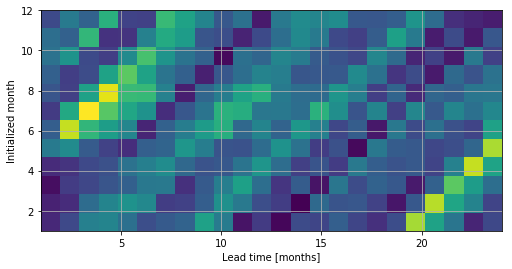

In [84]:
with utils.timer():
    fig1 = plt.figure(figsize=(8,4))

    ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.grid()
    ax.imshow(rms_error, extent=[1,24,1,12])
    ax.set_xlabel('Lead time [months]')
    ax.set_ylabel('Initialized month');

In [85]:
corrcoef_fcst = skill.compute_Pearson_corrcoef(soi_fcst, soi_obsv, over_dims=['lead_time','ensemble'])

fcst_monthly = corrcoef_fcst.groupby('init_date.month').mean(dim='init_date')

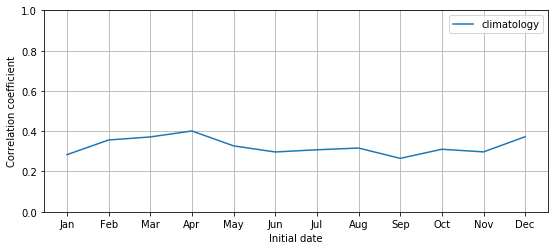

In [86]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig1 = plt.figure(figsize=(10,4))

ax1 = fig1.add_axes([0.1, 0.5, 0.7, 0.7])
ax1.grid()
ax1.plot(fcst_monthly['month'],fcst_monthly)
ax1.set_xticks(range(1,13))
ax1.set_xticklabels(months)
ax1.set_xlabel('Initial date')
ax1.set_ylabel('Correlation coefficient')
ax1.set_ylim(0,1)
ax1.legend(['climatology','forecast']);

# Close dask client

In [ ]:
# with utils.timer():
#     client.close()